In [ ]:
api_key = ''
base_url = 'https://openai.api.proxyapi.ru/v1'
model = 'openai/gpt-5-mini'

In [ ]:
%%capture
!pip install langchain==1.2.3 langchain_openai==1.1.7 langchain-community==0.4.1 langchain-text-splitters pypdf faiss-cpu

In [ ]:
import os
import requests
from bs4 import BeautifulSoup
from typing import List, Literal, Union, Dict, Callable
from pydantic import BaseModel, Field
from pprint import pprint
from langchain.tools import tool
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import (
    ChatPromptTemplate,
    PromptTemplate,
    FewShotPromptTemplate
)

from langchain_core.runnables import RunnableLambda
from langchain.agents import create_agent
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain_core.runnables import chain
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

from IPython.display import Image, display

import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [ ]:
os.environ["OPENAI_API_KEY"] = api_key
os.environ["OPENAI_BASE_URL"] = base_url

llm = ChatOpenAI(model=model)

# Техники промптинга

## Zero-shot

**Zero-shot** — техника промптинга, когда модель выполняет задачу без единого примера в промпте или обучении на целевых классах/данных.

Модель опирается на предобученные знания, семантику инструкции и обобщение: например, классифицирует новые категории объектов по описанию ("это животное с крыльями и клювом") или генерирует текст по команде "переведи на французский".

In [ ]:
prompt = ChatPromptTemplate.from_messages(
 [
            (
                "system",
                "Ты строгий, но понятный преподаватель математики для старшеклассников.",
            ),
            (
                "user",
                "Объясни, что такое производная функции в точке, "
                "и реши пример: найти производную f(x) = 3x^2 - 5x + 1.",
            ),
        ]
)

chain = prompt | llm
resp = chain.invoke({})
print("=== ZERO-SHOT ===")
print(resp.content)

=== ZERO-SHOT ===
Производная функции в точке — это предел приращения функции к приращению аргумента, когда приращение аргумента стремится к нулю. Формально, для функции f в точке x это
f'(x) = lim_{h→0} (f(x+h) − f(x)) / h,
если этот предел существует.

Интерпретации:
- Геометрически: производная в точке — это тангенс угла наклона касательной к графику функции в этой точке (то есть угловой коэффициент касательной).
- Физически: это мгновенная скорость изменения величины f по отношению к x (например, скорость изменения координаты по времени).

Решение примера f(x) = 3x^2 − 5x + 1.

Вычислим разностную частицу и предел:
f(x+h) = 3(x+h)^2 − 5(x+h) + 1 = 3x^2 + 6xh + 3h^2 − 5x − 5h + 1.
Тогда
(f(x+h) − f(x)) / h = (6xh + 3h^2 − 5h) / h = 6x + 3h − 5.
При h → 0 получаем f'(x) = 6x − 5.

Итого: производная функции f равна f'(x) = 6x − 5.

Если нужно значение в конкретной точке, подставьте x. Например, f'(2) = 6·2 − 5 = 7, а уравнение касательной в точке x=2:
y = f(2) + f'(2)(x − 2). (Здесь 

## Few-Shot

Few-shot — техника промптинга, когда модель выполняет задачу с несколькими примерами (обычно 1–5) в промпте для целевых классов/данных.

Модель опирается на предобученные знания, семантику инструкции и обобщение из примеров: например, классифицирует новые категории объектов по 2–3 образцам ("птица: фото1, фото2") или генерирует текст по шаблону с парами "ввод → вывод".

In [ ]:
examples = [
        {
            "problem": "Решить уравнение x^2 - 5x + 6 = 0.",
            "category": "algebra_equation",
        },
        {
            "problem": "Найти площадь треугольника по формуле Герона.",
            "category": "geometry_area",
        },
        {
            "problem": "Вычислить предел lim_x→0 (sin x)/x.",
            "category": "calculus_limit",
        },
    ]

example_prompt = PromptTemplate(
        input_variables=["problem", "category"],
        template="Задача: {problem}\nКатегория: {category}\n",
    )

prefix = (
        "Ты классифицируешь математические задачи по типу.\n"
        "Всегда отвечай одним ярлыком категории (одно слово или snake_case)."
    )
suffix = "Задача: {problem}\nКатегория:"

few_shot_prompt = FewShotPromptTemplate(
        examples=examples,
        example_prompt=example_prompt,
        prefix=prefix,
        suffix=suffix,
        input_variables=["problem"],
    )

In [ ]:
chain = few_shot_prompt | llm
resp = chain.invoke(
        {
            "problem": "Найти определённый интеграл ∫_0^1 (2x + 1) dx."
        }
    )

print("=== FEW-SHOT ===")
print(resp.content.strip())

=== FEW-SHOT ===
calculus_integral


## Chain of Thought

Chain of Thought (CoT) — техника промптинга, побуждающая модель генерировать промежуточные шаги рассуждений перед финальным ответом ("Давай подумаем шаг за шагом").

In [ ]:
cot_system = """
Ты помощник по математике и всегда решаешь задачи по шагам.

Формат ответа:
1) Сначала коротко переформулируй задачу.
2) Затем решай по шагам с пояснениями.
3) В конце выведи строку строго в формате:
Итоговый ответ: <число или выражение>
"""

cot_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", cot_system),
            (
                "user",
                "У ученика было 4 контрольные работы с оценками 3, 4, 5 и 5.\n"
                "Он написал пятую работу и получил 4.\n"
                "Найди средний балл за все 5 работ.",
            ),
        ]
    )


In [ ]:
chain = cot_prompt | llm
resp = chain.invoke({})
print("=== CHAIN-OF-THOUGHT (ПОШАГОВОЕ РЕШЕНИЕ) ===")
print(resp.content)
print()

=== CHAIN-OF-THOUGHT (ПОШАГОВОЕ РЕШЕНИЕ) ===
1) Коротко: были оценки 3, 4, 5 и 5; добавилась пятая работа с оценкой 4. Нужно найти средний балл за все 5 работ.

2) Решение по шагам:
- Сумма первых четырёх оценок: 3 + 4 + 5 + 5 = 17.
- Добавляем оценку пятой работы: 17 + 4 = 21 — общая сумма баллов за 5 работ.
- Средний балл = общая сумма / количество работ = 21 / 5 = 4.2.

Итоговый ответ: 4.2



## Structured output

**Structured output (структурированный вывод)** — это формат ответа, в котором информация организована по заранее заданной структуре (например, поля JSON, таблица, объект), а не просто как свободный текст.

Модель должна вернуть данные строго по описанной схеме: фиксированные поля, ожидаемые типы значений и однозначная структура, чтобы ответ можно было автоматически парсить, проверять и передавать в другие системы или базы данных.

In [ ]:
class MathSolution(BaseModel):
  problem: str = Field(..., description="Формулировка задачи")
  steps: List[str] = Field(..., description="Основные шаги решения")
  final_answer: float | str = Field(..., description="Окончательный ответ (число или краткий текст)")


In [ ]:
structured_llm = llm.with_structured_output(MathSolution)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "Ты решаешь школьные математические задачи и возвращаешь "
            "строго объект с полями problem, steps, final_answer.",
        ),
        (
            "user",
            "Реши задачу: Найти значение выражения (5^2 - 3^2) / 4.",
        ),
    ]
)

In [ ]:
chain = prompt | structured_llm
result: MathSolution = chain.invoke({})
print("=== STRUCTURED OUTPUT (СТРУКТУРИРОВАННОЕ РЕШЕНИЕ) ===")
print(result)


=== STRUCTURED OUTPUT (СТРУКТУРИРОВАННОЕ РЕШЕНИЕ) ===
problem='Найти значение выражения (5^2 - 3^2) / 4.' steps=['Вычисляем квадраты: 5^2 = 25, 3^2 = 9.', 'Вычисляем разность: 25 - 9 = 16.', 'Делим на 4: 16 / 4 = 4.'] final_answer=4.0


In [ ]:
result.model_dump()

{'problem': 'Найти значение выражения (5^2 - 3^2) / 4.',
 'steps': ['Вычисляем квадраты: 5^2 = 25, 3^2 = 9.',
  'Вычисляем разность: 25 - 9 = 16.',
  'Делим на 4: 16 / 4 = 4.'],
 'final_answer': 4.0}

## SGR

**Schema‑Guided Reasoning (SGR)** — это Chain‑of‑Thought с поддержкой структурированного вывода: модель рассуждает пошагово и фиксирует каждый шаг в заранее определённой схеме (например, в полях JSON), обеспечивая согласованные, разбираемые и проверяемые результаты.

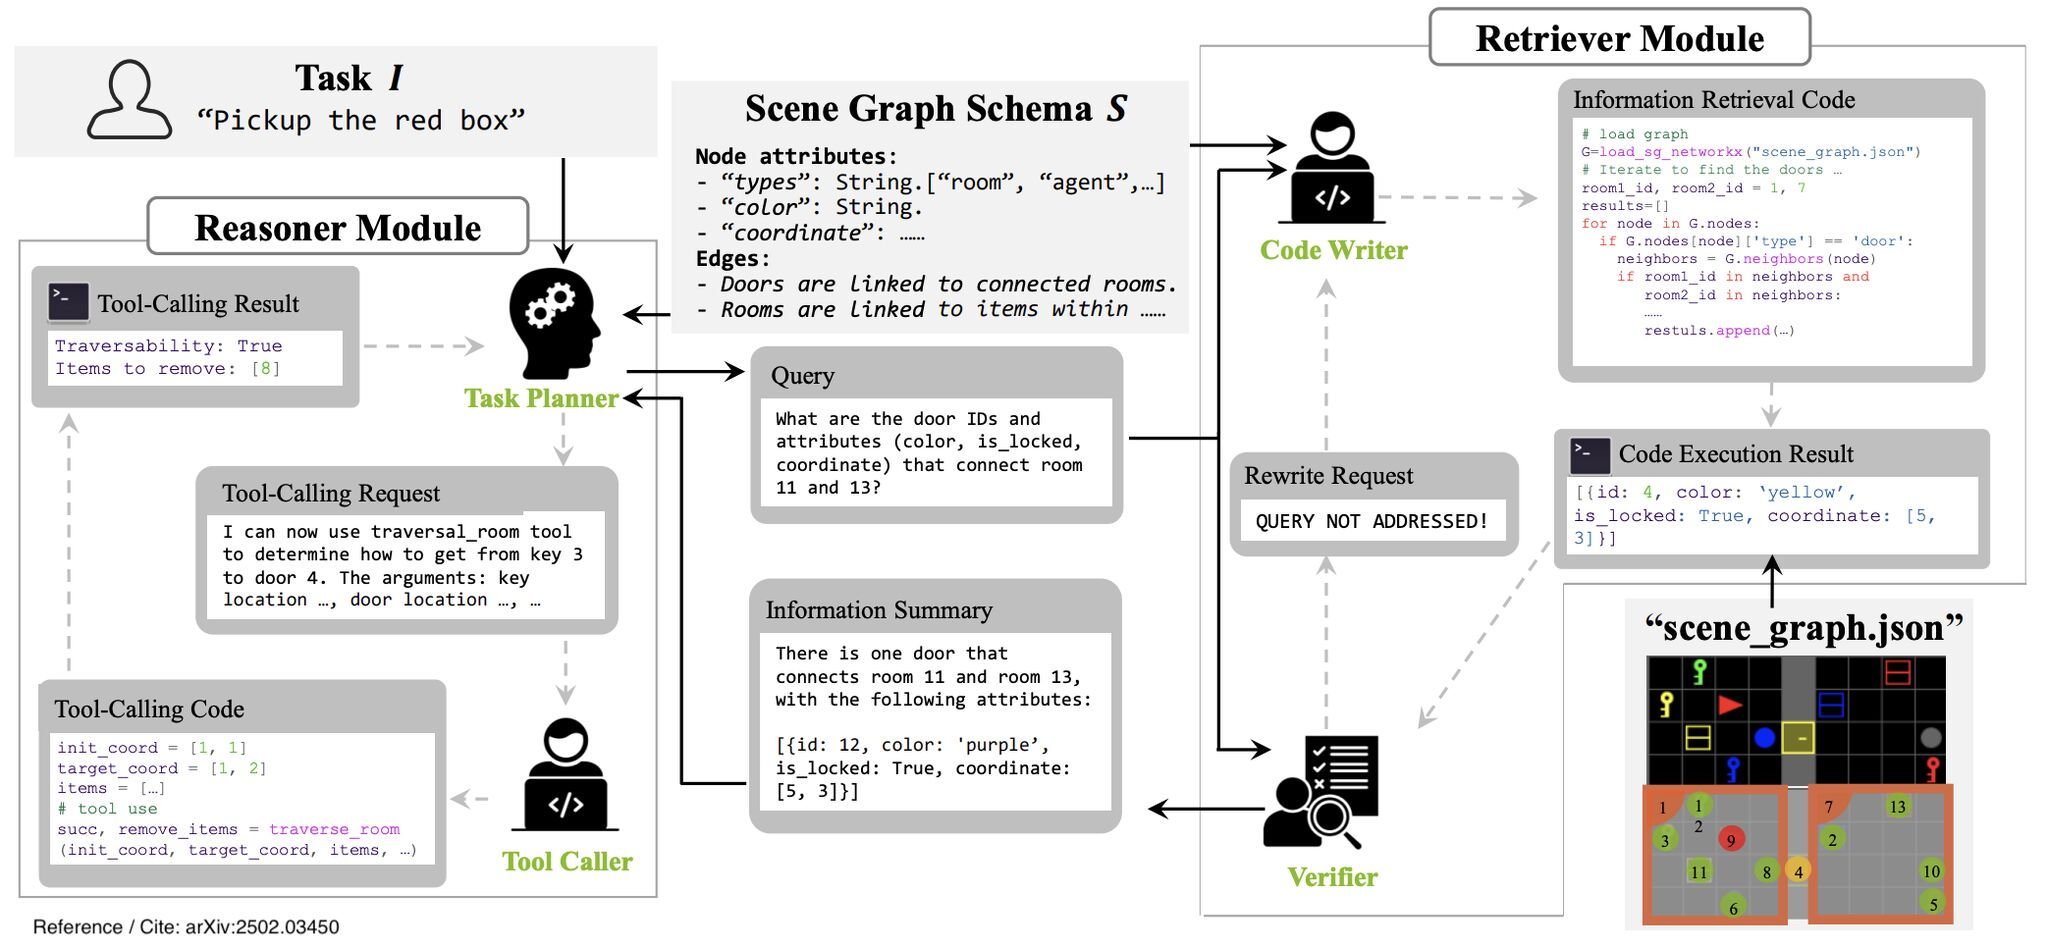

In [ ]:
class Step(BaseModel):
    explanation: str
    output: str

class MathReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

In [ ]:
sgr_llm = llm.with_structured_output(MathReasoning)
cot_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                "Реши уравнение 8x + 7 = -23. Рассуждай шаг за шагом.",
            ),
        ]
    )

In [ ]:
chain = cot_prompt | sgr_llm
result: MathReasoning = chain.invoke({})
print("=== SGR===")
result


=== SGR===


MathReasoning(steps=[Step(explanation='Вычтем 7 из обеих частей уравнения, чтобы избавиться от свободного члена на левой стороне.', output='8x = -23 - 7 = -30'), Step(explanation='Разделим обе части уравнения на 8, чтобы найти x.', output='x = -30/8 = -15/4 = -3.75')], final_answer='x = -15/4 (или x = -3.75)')

### SGR Patterns

Patterns в Schema-Guided Reasoning (SGR) — это повторно используемые workflows, которые определяют, как schema-constrained шаги следуют друг за другом, ветвятся или комбинируются для решения задачи.

Cascade: следуем шаг за шагом по заданной схеме.

Router: выбираем подходящую схему в зависимости от входной задачи.

Cycle: повторяем шаги по схеме несколько раз.

#### Cascade

Cascade pattern в Schema-Guided Reasoning — это многостадийный pipeline, где каждый schema-constrained шаг передаёт свой structured output следующему шагу, постепенно уточняя результат с опциональной валидацией или fallbackом на каждом этапе

In [ ]:
class Step1(BaseModel):
    problem_statement: str
    restated_problem: str

class Step2(BaseModel):
    transformations: list[str]

class Step3(BaseModel):
    calculations: list[str]
    intermediate_results: list[float]

class Step4(BaseModel):
    verification: bool

class Step5(BaseModel):
    final_answer: float

class CascadeMathProblem(BaseModel):
    step1: Step1
    step2: Step2
    step3: Step3
    step4: Step4
    step5: Step5

In [ ]:
sgr_llm = llm.with_structured_output(CascadeMathProblem)
cot_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                "Реши систему уравнений x+y=5, 2x−y=3",
            ),
        ]
    )

In [ ]:
chain = cot_prompt | sgr_llm
result: CascadeMathProblem = chain.invoke({})
print("=== SGR CascadeMathProblem ===")
result


=== SGR CascadeMathProblem ===


CascadeMathProblem(step1=Step1(problem_statement='Реши систему уравнений: x + y = 5, 2x − y = 3', restated_problem='Найти значения x и y, удовлетворяющие обеим уравнениям.'), step2=Step2(transformations=['Сложить оба уравнения, чтобы исключить y: (x + y) + (2x − y).', 'Получится уравнение только для x: 3x = 5 + 3.', 'Найти x и подставить в одно из исходных уравнений для нахождения y.']), step3=Step3(calculations=['Сложение уравнений: (x + y) + (2x − y) = 3x, справа: 5 + 3 = 8 → 3x = 8.', 'x = 8 / 3 ≈ 2.6666666666666665.', 'Подстановка в x + y = 5: y = 5 − x = 5 − 8/3 = 7/3 ≈ 2.3333333333333335.'], intermediate_results=[2.6666666666666665, 2.3333333333333335]), step4=Step4(verification=True), step5=Step5(final_answer=2.6666666666666665))

#### Routing

Routing pattern в SGR — это условная схема, которая выбирает, какую схему или этап запустить следующим — на основе входной задачи или предыдущих structured outputs, — чтобы каждый случай шёл в наиболее подходящий пайплайн.

In [ ]:
class AlgebraTask(BaseModel):
    kind: Literal["algebra"]
    equation: str
    solution_steps: list[str]
    answer: str

class GeometryTask(BaseModel):
    kind: Literal["geometry"]
    problem_statement: str
    figure_description: str
    solution_steps: list[str]
    answer: str

class CombinatoricsTask(BaseModel):
    kind: Literal["combinatorics"]
    problem_statement: str
    formula_used: str
    calculation_steps: list[str]
    answer: str

class MathProblem(BaseModel):
    task: Union[AlgebraTask, GeometryTask, CombinatoricsTask]

In [ ]:
sgr_llm = llm.with_structured_output(MathProblem)
cot_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                "Given a rectangle with an area S=24 and one side a=4, find the length of the other side b.",
            ),
        ]
    )

chain = cot_prompt | sgr_llm
result: MathProblem = chain.invoke({})
print("=== SGR MathProblem ===")
result

=== SGR MathProblem ===


MathProblem(task=AlgebraTask(kind='algebra', equation='a \\times b = S \\quad\\Rightarrow\\quad 4 \\times b = 24', solution_steps=['Use area formula for a rectangle: S = a \\times b.', 'Substitute given values: 4 \\times b = 24.', 'Solve for b: b = 24 / 4 = 6.', 'Check: 4 \\times 6 = 24, which matches S.'], answer='b = 6'))

In [ ]:
sgr_llm = llm.with_structured_output(MathProblem)
cot_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                "How many ways can you choose 2 people from a group of 5?",
            ),
        ]
    )

chain = cot_prompt | sgr_llm
result: MathProblem = chain.invoke({})
print("=== SGR MathProblem ===")
result

=== SGR MathProblem ===


MathProblem(task=CombinatoricsTask(kind='combinatorics', problem_statement='How many ways can you choose 2 people from a group of 5?', formula_used='Combination formula: C(n, k) = n! / (k!(n - k)!)', calculation_steps=['Compute C(5, 2) = 5! / (2! · 3!)', 'Simplify: 5! / (2! · 3!) = (5 · 4 · 3!) / (2 · 1 · 3!) = (5 · 4) / 2 = 20 / 2', 'Result: 10'], answer='10'))

#### Cycle

What it is: Цикл, который повторно применяет schema-constrained шаги — generate → evaluate/validate → repair/refine — до выполнения stop condition.

How it works: Каждая итерация принимает предыдущий structured output, проводит проверки по правилам и либо финализирует, либо генерирует revised output.

In [ ]:
class CycleStep(BaseModel):
    proposed_solution: str
    verification: bool
    errors_found: List[str]
    corrections: List[str]

class CycleGuidedMathProblem(BaseModel):
    problem_statement: str
    iterations: List[CycleStep]
    final_answer: str

In [ ]:
sgr_llm = llm.with_structured_output(CycleGuidedMathProblem)
cot_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "user",
                '''Consider the problem of finding an approximate solution to the nonlinear system of equations using the Newton-Raphson method:

x^2 + y^2 - 4 = 0
e^x + y - 1 = 0

## Problem Description

Find values of \(x\) and \(y\) satisfying the system with accuracy \(\varepsilon = 10^-5\).
''',
            ),
        ]
    )

chain = cot_prompt | sgr_llm
result: CycleGuidedMathProblem = chain.invoke({})
print("=== SGR CycleGuidedMathProblem ===")
result

<>:13: SyntaxWarning: invalid escape sequence '\('
<>:13: SyntaxWarning: invalid escape sequence '\('
/tmp/ipython-input-4270668357.py:13: SyntaxWarning: invalid escape sequence '\('
  Find values of \(x\) and \(y\) satisfying the system with accuracy \(\varepsilon = 10^-5\).


=== SGR CycleGuidedMathProblem ===


CycleGuidedMathProblem(problem_statement='Solve the nonlinear system\nx^2 + y^2 - 4 = 0\ne^x + y - 1 = 0\nwith accuracy epsilon = 1e-5 using the Newton-Raphson method.', iterations=[CycleStep(proposed_solution='Initial guess: x0 = 1.000000, y0 = -1.700000.\nf(x0,y0) = [x0^2 + y0^2 - 4, e^{x0} + y0 - 1] = [-0.110000, 0.0182828].', verification=False, errors_found=['Residual norm ||f|| = sqrt((-0.11)^2 + (0.01828)^2) ≈ 0.1115 > 1e-5 (not converged).'], corrections=['Compute Newton step: solve J(x0,y0) Δ = f(x0,y0) and set (x1,y1) = (x0,y0) - Δ.']), CycleStep(proposed_solution='After 1st Newton update: x1 = 1.004260, y1 = -1.729840.\nComputed correction Δ ≈ [-0.004260, 0.029840].\nResidual f(x1,y1) ≈ [0.000892, -1.0e-05].', verification=False, errors_found=['Residual components not yet below tolerance: max(|f1|,|f2|) ≈ 8.92e-04 > 1e-5.'], corrections=['Perform another Newton update from (x1,y1).']), CycleStep(proposed_solution='After 2nd Newton update: x2 = 1.004185, y2 = -1.729626.\nComp

# Первый мини-RAG (векторный поиск)

**RAG (Retrieval Augmented Generation)** — техника, где LLM сначала извлекает релевантные данные из внешней базы знаний (retrieval), а затем генерирует ответ на их основе, снижая галлюцинации и повышая точность.

**Этапы пайплайна**
- Indexing (индексация): Документы загружаются и разбиваются на чанки, преобразуются в embeddings и сохраняются в векторную БД (например, FAISS, Pinecone) (на рисунке ниже).

- Retrieval (поиск): По запросу формируется embedding, находят top-K похожих chunks по cosine similarity или ANN.

- Augmentation (обогащение): Релевантные чанки вставляются в промпт как контекст ("На основе этих документов ответь...").

- Generation (генерация): LLM генерирует ответ, опираясь на промпт + релевантные данные.

Опционально: reranking (переранжирование chunks), query rewriting, multi-query retrieval.

Более подробно про RAG можно почитать [здесь](https://habr.com/ru/articles/893356/)

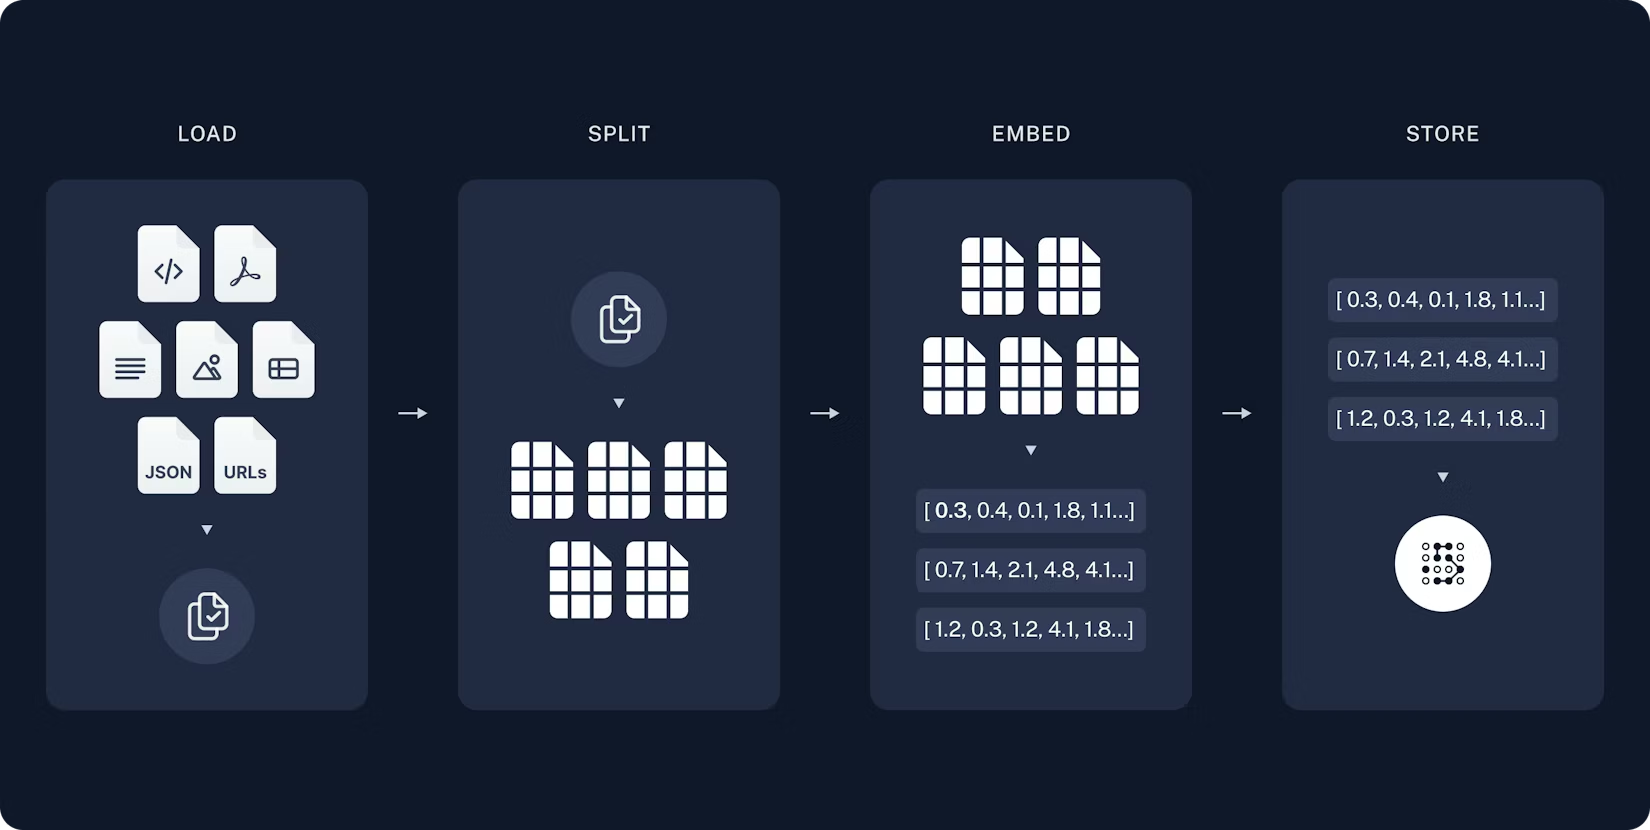

## Загружаем данные

**LangChain document loaders**— это компоненты фреймворка LangChain для загрузки данных из внешних источников в унифицированный формат Document (текст + метаданные).

**Основные методы**
- load(): загружает все документы сразу.

- lazy_load(): потоковая загрузка для больших датасетов.

- load_and_split(): загрузка + разбиение на чанки.

**Типы загрузчиков**
- Файловые: PDF (PyPDFLoader), DOCX, CSV, TXT, JSON, EPUB.

- Веб: HTML, веб-страницы, YouTube-транскрипты.

- Облачные: Google Drive, Notion, Confluence, GitHub, Airtable.

[Подробное описание document loaders из langchain](https://docs.langchain.com/oss/python/integrations/document_loaders)

In [ ]:
file_path = "https://raw.githubusercontent.com/langchain-ai/langchain/v0.3/docs/docs/example_data/nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

In [ ]:
print(len(docs))
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

107
Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
FORM 10-K
(Mark One)
☑ ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(D) OF THE SECURITIES EXCHANGE ACT OF 1934
FO

{'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': 'https://raw.githubusercontent.com/langchain-ai/langchain/v0.3/docs/docs/example_data/nke-10k-2023.pdf', 'total_pages': 107, 'page': 0, 'page_label': '1'}


## Split

**LangChain text splitters** разбивают большие тексты на чанки подходящего размера для LLM (учитывая лимиты контекста), сохраняя семантику и добавляя overlap для continuity.

**Основные типы**
- RecursiveCharacterTextSplitter: Рекурсивно режет по разделителям ("\n\n", "\n", ".", " !", " "), идеален для общего текста.

- CharacterTextSplitter: Простой разрез по символам (chunk_size, chunk_overlap).
​

- TokenTextSplitter: Разбиение по токенам модели (tiktoken), экономит на API-костах.

**Параметры**
- chunk_size: макс. размер чанка (символы/токены).

- chunk_overlap: перекрытие (10-20% от size) для контекста между чанками.

[Подробнее здесь](https://docs.langchain.com/oss/python/integrations/splitters)



In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

print(len(all_splits))

516


## Embed

In [ ]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [ ]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 1536

[0.053715188056230545, 0.04887084662914276, 0.018866805359721184, -0.004853245336562395, 0.025005346164107323, -0.008216381072998047, -0.006358196958899498, 0.02417420782148838, -0.0011346501996740699, 0.010858208872377872]


## Store

LangChain vector stores — это интерфейс для хранения эмбеддингов документов и выполнения поиска по схожести (similarity search), ключевой компонент RAG-пайплайнов. [docs.langchain](https://docs.langchain.com/oss/python/integrations/vectorstores)

**Основные методы**
- `add_documents()` / `from_documents()`: добавление документов с автоматическим эмбеддингом.
- `similarity_search()`: поиск топ-k похожих по запросу (с score).
- `delete()`: удаление по ID или фильтру. [docs.langchain](https://docs.langchain.com/oss/javascript/integrations/vectorstores)

**Популярные реализации**
| Тип | Пример | Особенности |
|-----|--------|-------------|
| In-memory | `InMemoryVectorStore` | Для тестов, без персистенции  [docs.langchain](https://docs.langchain.com/oss/python/integrations/vectorstores) |
| Локальные | `FAISS`, `Chroma` | Быстрый поиск, сохранение на диск  [habr](https://habr.com/ru/articles/904418/) |
| Облачные | `Pinecone`, `Weaviate`, MongoDB Atlas | Масштабируемость, управляемые  [langchain-cn.readthedocs](https://langchain-cn.readthedocs.io/en/latest/reference/modules/vectorstore.html) |

In [ ]:
index = faiss.IndexFlatL2(len(vector_1))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

ids = vector_store.add_documents(documents=all_splits)

In [ ]:
results = vector_store.similarity_search(
    "Сколько распределительных центров у компании Nike в США?"
)

print(results[0])

page_content='direct to consumer operations sell products through the following number of retail stores in the United States:
U.S. RETAIL STORES NUMBER
NIKE Brand factory stores 213 
NIKE Brand in-line stores (including employee-only stores) 74 
Converse stores (including factory stores) 82 
TOTAL 369 
In the United States, NIKE has eight significant distribution centers. Refer to Item 2. Properties for further information.
2023 FORM 10-K 2' metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': 'https://raw.githubusercontent.com/langchain-ai/langchain/v0.3/docs/docs/example_data/nke-10k-2023.pdf', 'total_pages': 107, 'page'

In [ ]:
results = vector_store.similarity_search_with_score("What was Nike's revenue in 2023?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 0.5632922649383545

page_content='Table of Contents
FISCAL 2023 NIKE BRAND REVENUE HIGHLIGHTSThe following tables present NIKE Brand revenues disaggregated by reportable operating segment, distribution channel and major product line:
FISCAL 2023 COMPARED TO FISCAL 2022
• NIKE, Inc. Revenues were $51.2 billion in fiscal 2023, which increased 10% and 16% compared to fiscal 2022 on a reported and currency-neutral basis, respectively.
The increase was due to higher revenues in North America, Europe, Middle East & Africa ("EMEA"), APLA and Greater China, which contributed approximately 7, 6,
2 and 1 percentage points to NIKE, Inc. Revenues, respectively.
• NIKE Brand revenues, which represented over 90% of NIKE, Inc. Revenues, increased 10% and 16% on a reported and currency-neutral basis, respectively. This
increase was primarily due to higher revenues in Men's, the Jordan Brand, Women's and Kids' which grew 17%, 35%,11% and 10%, respectively, on a wholesale
equivalent basis.' metad

In [ ]:
results = vector_store.similarity_search_with_score("Какова была выручка Nike в 2023 году?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

Score: 0.8705106973648071

page_content='$1,151 million in fiscal 2022.
In fiscal 2023, we purchased a total of 50.0 million shares of NIKE's Class B Common Stock for $5.5 billion (an average price of $110.32 per share). In August 2022, we
terminated the previous four-year, $15 billion share repurchase program approved by the Board of Directors in June 2018. Under this program, we repurchased 6.5 million
shares for a total approximate cost of $710.0 million (an average price of $109.85 per share) during the first quarter of fiscal 2023 and 83.8 million shares for a total
approximate cost of $9.4 billion (an average price of $111.82 per share) during the term of the program. Upon termination of the four-year, $15 billion program, we began
purchasing shares under the new four-year, $18 billion share repurchase plan authorized by the Board of Directors in June 2022. As of May 31, 2023, we had' metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Conve

## Поиск релевантных чанков

In [ ]:
questions = [
        "How many distribution centers does Nike have in the US?",
        "When was Nike incorporated?",
    ]

retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

retriever.batch(
   questions,
)

[[Document(id='3231779a-3f11-4f88-8e77-2dd76ecfb5b0', metadata={'producer': 'EDGRpdf Service w/ EO.Pdf 22.0.40.0', 'creator': 'EDGAR Filing HTML Converter', 'creationdate': '2023-07-20T16:22:00-04:00', 'title': '0000320187-23-000039', 'author': 'EDGAR Online, a division of Donnelley Financial Solutions', 'subject': 'Form 10-K filed on 2023-07-20 for the period ending 2023-05-31', 'keywords': '0000320187-23-000039; ; 10-K', 'moddate': '2023-07-20T16:22:08-04:00', 'source': 'https://raw.githubusercontent.com/langchain-ai/langchain/v0.3/docs/docs/example_data/nke-10k-2023.pdf', 'total_pages': 107, 'page': 4, 'page_label': '5', 'start_index': 3125}, page_content='direct to consumer operations sell products through the following number of retail stores in the United States:\nU.S. RETAIL STORES NUMBER\nNIKE Brand factory stores 213 \nNIKE Brand in-line stores (including employee-only stores) 74 \nConverse stores (including factory stores) 82 \nTOTAL 369 \nIn the United States, NIKE has eight

## Генерация

In [ ]:
prompt = ChatPromptTemplate.from_template(
    "You are a helpful assistant. Use ONLY the context below.\n\n"
    "Context:\n{context}\n\n"
    "Question: {input}\n"
)

# LCEL chain: retriever | format_docs | prompt | llm | parser
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "input": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
results = rag_chain.batch(questions, config={"max_concurrency": 5})

In [ ]:
results

['Nike has eight distribution centers in the United States.',
 'Nike was incorporated in 1967.']

# Function calling и инструменты

LLM-агент — это автономная система на базе большой языковой модели (LLM), которая воспринимает окружающую среду, планирует действия, использует инструменты и достигает целей без жесткого скрипта.

**Ключевые компоненты**
- **LLM-ядро**: рассуждение, планирование, генерация шагов.
- **Память**: долгосрочная для контекста и опыта.
- **Инструменты**: API, поиск, код — для внешних действий.
- **Планировщик**: ReAct, Plan-and-Execute для сложных задач.

[Подробнее про агентов](https://docs.langchain.com/oss/python/langchain/agents)

**Преимущества**
- **Автономность**: Выполняют многошаговые задачи без постоянного вмешательства человека, используя планирование и инструменты.
- **Адаптивность**: Учатся на опыте, корректируют планы по обратной связи, адаптируются к новым условиям.
- **Эффективность**: Ускоряют процессы, снижают затраты, автоматизируют рутину (разработка, аналитика, поддержка).

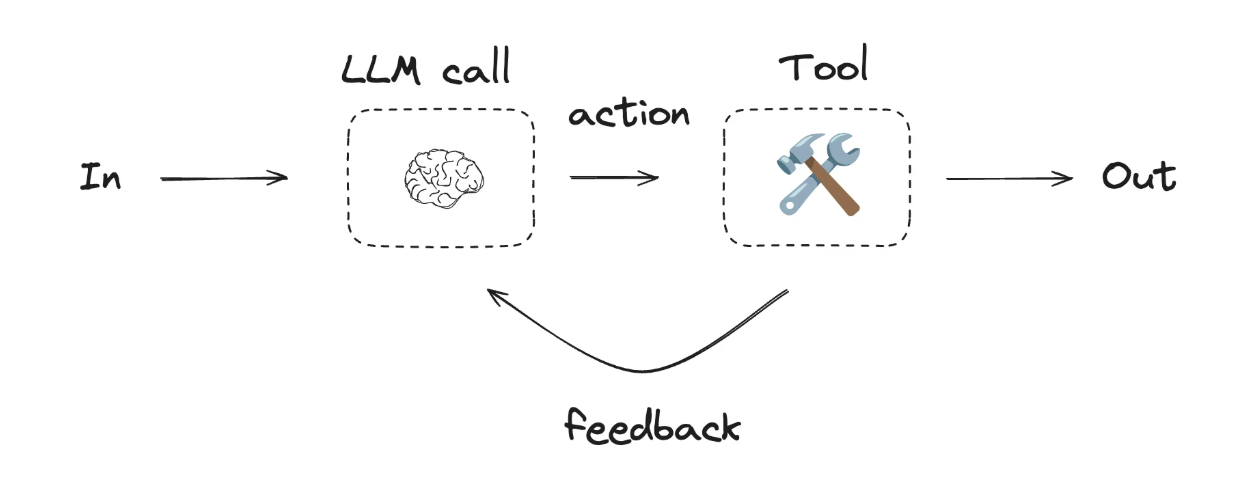

## Полная имплементация ReAct агента

ReAct (https://arxiv.org/abs/2210.03629) интегрирует рассуждение и действия в пределах LLM, расширяя пространство действий до комбинации конкретных для задач дискретных действий и языкового пространства. Первое позволяет LLM взаимодействовать с окружающей средой (например, использовать API поиска по Википедии), в то время как второе подталкивает LLM к созданию следов рассуждений на естественном языке.

Шаблон подсказки ReAct включает явные шаги для размышлений LLM, примерно оформленные как:

```
Thought: ...
Action: ...
Observation: ...
... (Repeated many times)
```


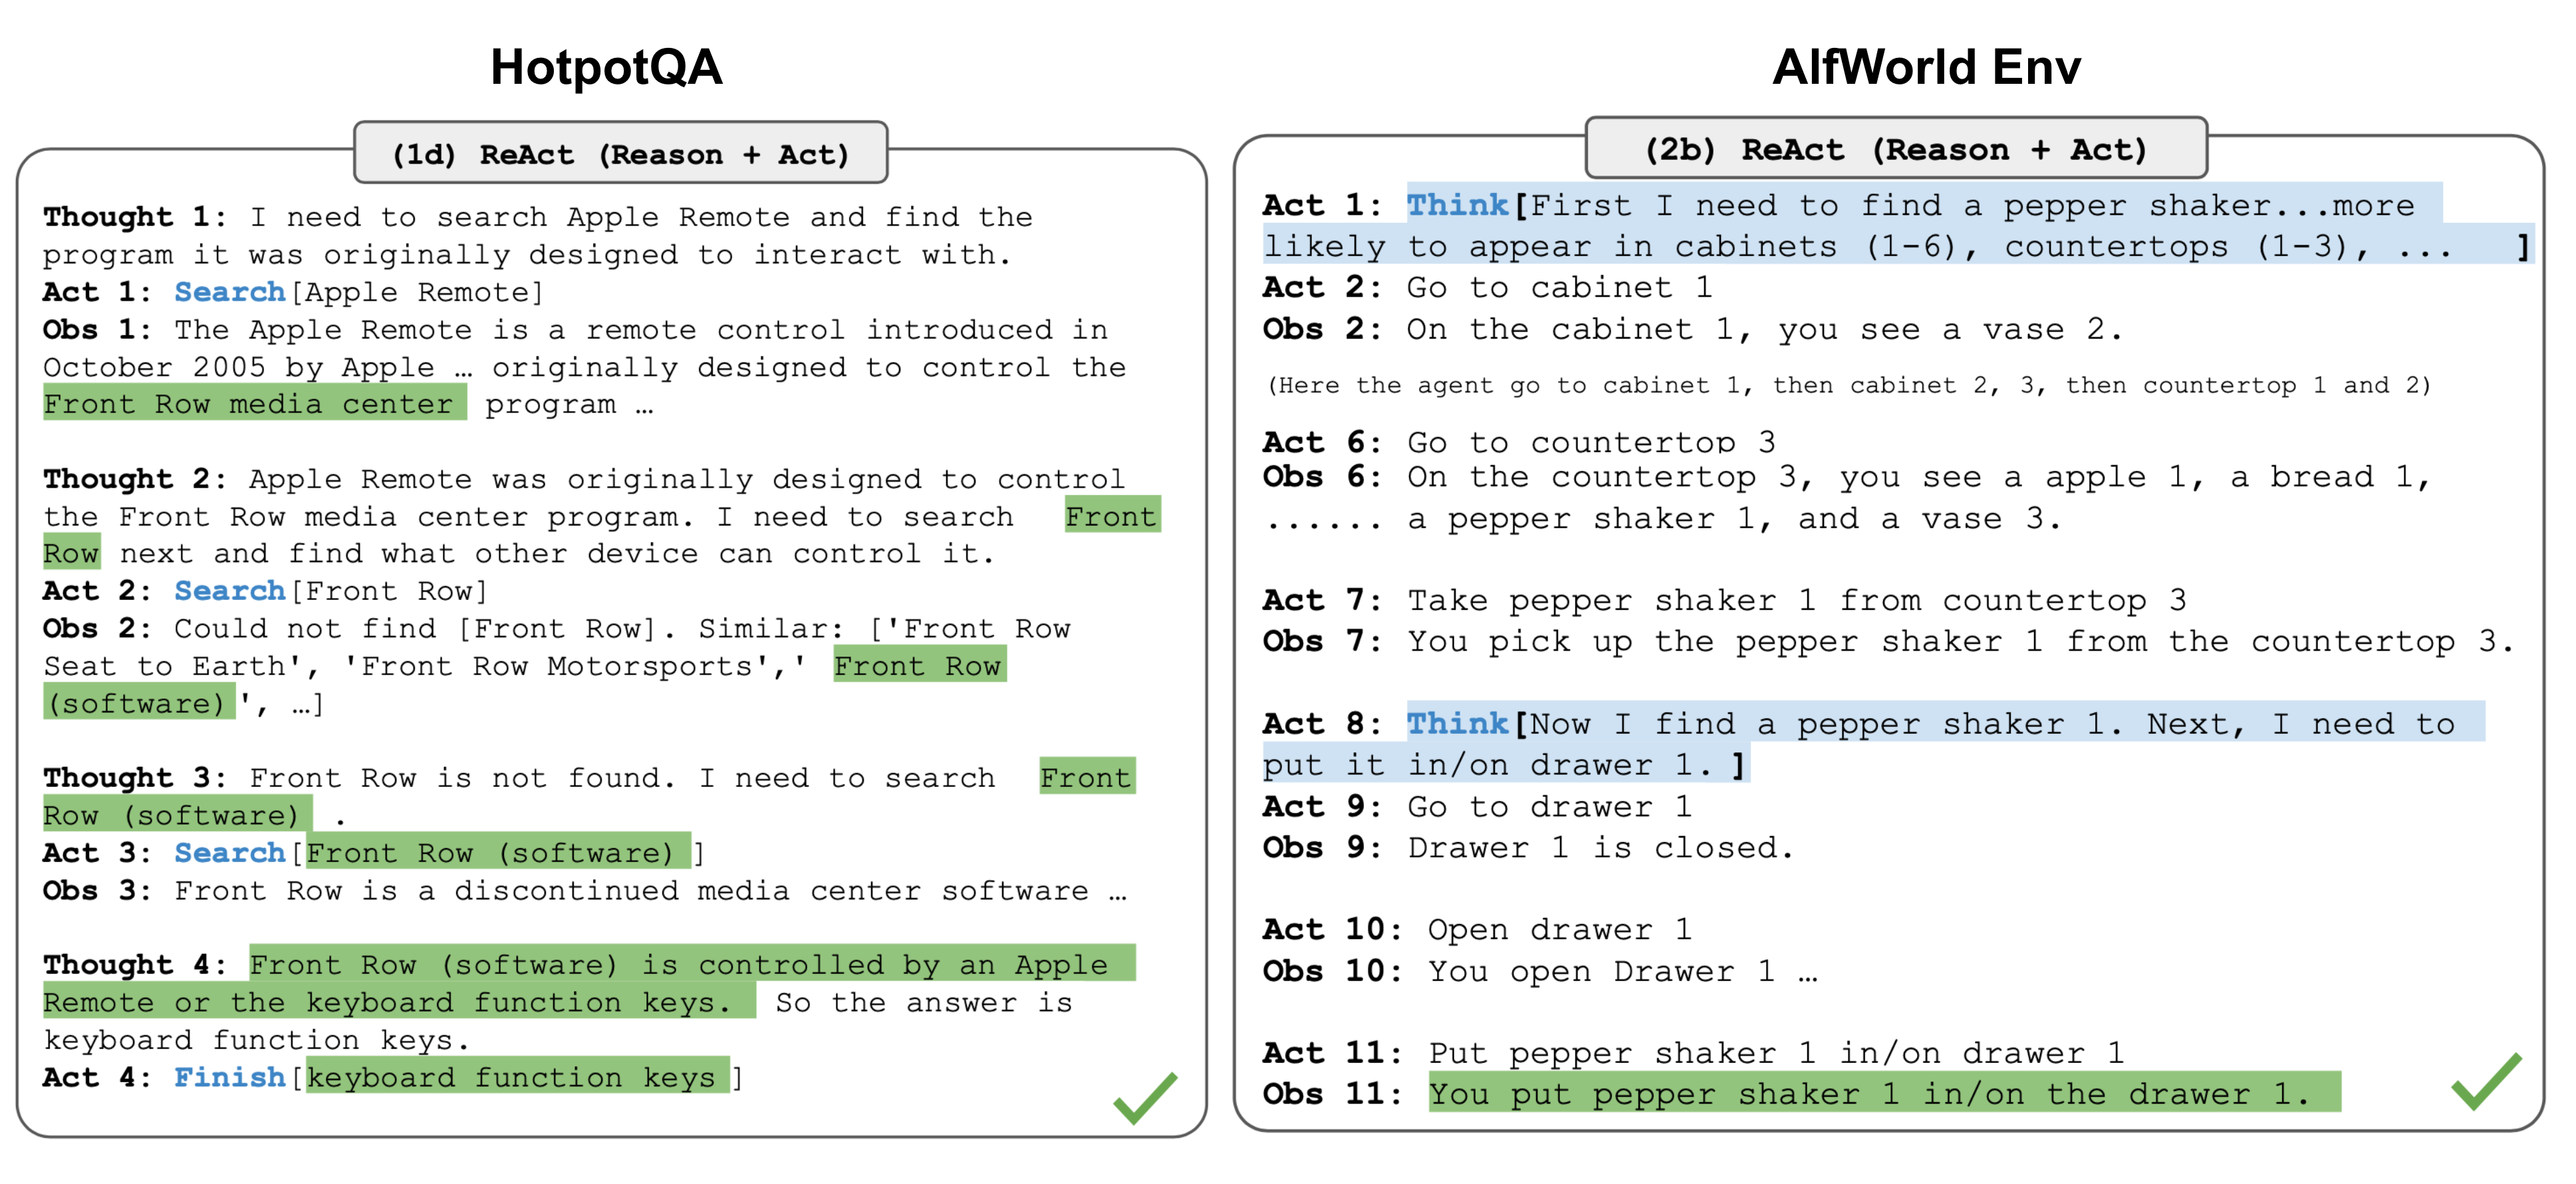


In [ ]:
def _tool_calculator(expr: str) -> str:
    """
    Очень простой и небезопасный калькулятор, только для демо!
    В реальном коде eval использовать нельзя без жёсткого sandbox.
    """
    try:
        result = eval(expr, {"__builtins__": {}})
        return str(result)
    except Exception as e:
        return f"error: {e}"

In [ ]:
react_system = """
Ты решаешь текстовые задачи по математике и можешь пользоваться инструментом:

- calculator(выражение): вычисляет простые арифметические выражения на Python.

Стратегия ReAct:
- Сначала думай, нужен ли инструмент.
- Если используешь инструмент, следуй формату:

Thought: нужно ли использовать calculator?
Action: calculator
Action Input: <арифметическое выражение>

Затем ты получаешь:

Observation: <результат_инструмента>

После этого продолжай рассуждение и закончи ответ строкой:

Final Answer: <окончательный числовой ответ и краткое пояснение>
"""

def run_react(_: dict):
    # Первый проход: модель решает, вызывать ли calculator
    first_step = (react_prompt | llm).invoke({})
    text = first_step.content

    action = None
    action_input = None
    for line in text.splitlines():
        if line.startswith("Action:"):
            action = line.split("Action:")[1].strip()
        if line.startswith("Action Input:"):
            action_input = (
                line.split("Action Input:")[1].strip().strip("`")
            )

    observation = ""
    if action == "calculator" and action_input:
        observation = _tool_calculator(action_input)

    # Второй проход: даём Observation и просим финальный ответ
    react_continuation_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", react_system),
            ("user", user_question),
            ("assistant", text),
            ("user", f"Observation: {observation}"),
        ]
    )
    second_step = (react_continuation_prompt | llm).invoke({})
    print("=== REACT-СТИЛЬ (КАЛЬКУЛЯТОР ДЛЯ ЗАДАЧИ) ===")
    print("ПЕРВЫЙ ШАГ МОДЕЛИ:\n", text, "\n")
    print("ВТОРОЙ ШАГ (С УЧЁТОМ OBSERVATION):\n", second_step.content)
    print()

In [ ]:
user_question = (
        "В классе 30 учеников. 40% из них участвовали в олимпиаде по математике.\n"
        "Сколько учеников участвовали в олимпиаде?"
    )

react_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", react_system),
            ("user", user_question),
        ]
    )
chain = RunnableLambda(run_react)
chain.invoke({})

=== REACT-СТИЛЬ (КАЛЬКУЛЯТОР ДЛЯ ЗАДАЧИ) ===
ПЕРВЫЙ ШАГ МОДЕЛИ:
 40% от 30 = 0.4 × 30 = 12. Значит 12 учеников участвовали в олимпиаде. 

ВТОРОЙ ШАГ (С УЧЁТОМ OBSERVATION):
 Thought: нужно ли использовать calculator? Да — посчитаем 40% от 30.
Action: calculator
Action Input: 0.4*30
Observation: 12
Final Answer: 12 учеников участвовали в олимпиаде.



## Имплементация из коробки

In [ ]:
agent = create_agent(
    model=llm,
    tools=[_tool_calculator],
    system_prompt=react_system
)


In [ ]:
result = agent.invoke({
    "messages": [
        {"role": "user", "content": "В классе 30 учеников. 40% из них участвовали в олимпиаде по математике.\nСколько учеников участвовали в олимпиаде?"}
    ]
})

In [ ]:
pprint(result)

{'messages': [HumanMessage(content='В классе 30 учеников. 40% из них участвовали в олимпиаде по математике.\nСколько учеников участвовали в олимпиаде?', additional_kwargs={}, response_metadata={}, id='26b14519-fa7f-4ab2-8db6-e8a35b18390c'),
              AIMessage(content='Thought: нужно ли использовать calculator? Да, нужно вычислить 40% от 30.\nAction: calculator\nAction Input: 0.4*30', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 516, 'prompt_tokens': 322, 'total_tokens': 838, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 448, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5-mini-2025-08-07', 'system_fingerprint': None, 'id': 'chatcmpl-D3JolS6u3IkZwB6DFfFDeFd76wiUZ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019c095b-c3a1-7a10-a8ef-336

#  Агент с RAG в качестве инструмента

## Создаем базу знаний

In [ ]:
urls = [
    "https://education.yandex.ru/handbook/ml/article/yazykovye-modeli",
    "https://education.yandex.ru/handbook/ml/article/diffuzionnye-modeli",
    "https://education.yandex.ru/handbook/ml/article/generativno-sostyazatelnye-seti-(gan)",
]

def load_russian_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36"
    }

    response = requests.get(url, headers=headers, timeout=30)
    response.encoding = 'utf-8'  # ПРИНУДИТЕЛЬНО UTF-8

    soup = BeautifulSoup(response.text, 'html.parser')

    # Убираем ненужное (опционально)
    for script in soup(["script", "style", "nav", "footer"]):
        script.decompose()

    text = soup.get_text(separator='\n', strip=True)

    return [Document(page_content=text, metadata={"source": url})]

docs = [load_russian_page(url) for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
doc_splits[0].page_content.strip()

'Языковые модели\nЯндекс Образование — Личный кабинет\nВойти в ID\nВойти в ID\nСодержание\nЗаметки\nСодержание\n8.6 Языковые модели\nАвторы\nЕвгений Косарев\nВ 2023 году ChatGPT стал самой узнаваемой языковой моделью машинного обучения во всём мире — причём как среди специалистов, так и среди обычных людей.\nСпособность вести осмысленный диалог, отвечать на практически любые вопросы и быть применимыми без дообучения в большом спектре задач с высоким качеством — вот залог их  популярности.\nВ этом параграфе мы расскажем, что такое языковые модели, как они устроены, как развивались, а также как изменились за последнее время.\nЧто такое языковые модели?\nГоворя простым языком, языковые модели — это алгоритмы, способные продолжать тексты. Если чуть усложнить, то это\nвероятностные алгоритмы\n, и к ним сразу можно задать эмпирический критерий качества: хорошая модель даёт разумные продолжения данных ей текстов.'

In [ ]:
index = faiss.IndexFlatL2(len(vector_1))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

ids = vector_store.add_documents(documents=doc_splits)

retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

## Создаем retriever в качестве тула

In [ ]:
@tool
def retrieve_blog_posts(query: str) -> str:
    """Search and return information from Yandex ML Handbook."""
    docs = retriever.invoke(query)
    return "\n\n".join([doc.page_content for doc in docs])

retriever_tool = retrieve_blog_posts

In [ ]:
retriever_tool.invoke({"query": "что такое языковая модель?"})

'Языковые модели\nЯндекс Образование — Личный кабинет\nВойти в ID\nВойти в ID\nСодержание\nЗаметки\nСодержание\n8.6 Языковые модели\nАвторы\nЕвгений Косарев\nВ 2023 году ChatGPT стал самой узнаваемой языковой моделью машинного обучения во всём мире — причём как среди специалистов, так и среди обычных людей.\nСпособность вести осмысленный диалог, отвечать на практически любые вопросы и быть применимыми без дообучения в большом спектре задач с высоким качеством — вот залог их  популярности.\nВ этом параграфе мы расскажем, что такое языковые модели, как они устроены, как развивались, а также как изменились за последнее время.\nЧто такое языковые модели?\nГоворя простым языком, языковые модели — это алгоритмы, способные продолжать тексты. Если чуть усложнить, то это\nвероятностные алгоритмы\n, и к ним сразу можно задать эмпирический критерий качества: хорошая модель даёт разумные продолжения данных ей текстов.'

## Финальное построение агента

In [ ]:
def generate_query_or_respond(state: MessagesState):
    """Call the model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply respond to the user.
    """
    response = (
        llm.bind_tools([retriever_tool]).invoke(state["messages"])
    )
    return {"messages": [response]}

GENERATE_PROMPT = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer the question. "
    "If you don't know the answer, just say that you don't know. "
    "Use three sentences maximum and keep the answer concise.\n"
    "Question: {question} \n"
    "Context: {context}"
)


def generate_answer(state: MessagesState):
    """Generate an answer."""
    question = state["messages"][0].content
    context = state["messages"][-1].content
    prompt = GENERATE_PROMPT.format(question=question, context=context)
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"messages": [response]}

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node(generate_query_or_respond)
workflow.add_node("retrieve", ToolNode([retriever_tool]))
workflow.add_node(generate_answer)


workflow.add_edge(START, "generate_query_or_respond")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "generate_query_or_respond",
    # Assess LLM decision (call `retriever_tool` tool or respond to the user)
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

workflow.add_edge("retrieve", "generate_answer")

workflow.add_edge("generate_answer", END)

In [ ]:
graph = workflow.compile()

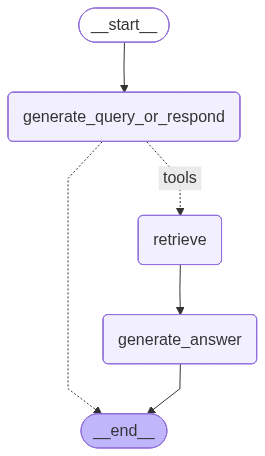

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for chunk in graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "что такое языковая модель согласно Yandex ML Handbook?",
            }
        ]
    }
):
  for node, update in chunk.items():
      print("Update from node", node)
      update["messages"][-1].pretty_print()
      print("\n\n")

Update from node generate_query_or_respond
================================== Ai Message ==================================
Tool Calls:
  retrieve_blog_posts (call_Za11xia9RwqXtfWG9wl2g1Jb)
 Call ID: call_Za11xia9RwqXtfWG9wl2g1Jb
  Args:
    query: что такое языковая модель Yandex ML Handbook



Update from node retrieve
================================= Tool Message =================================
Name: retrieve_blog_posts

Языковые модели
Яндекс Образование — Личный кабинет
Войти в ID
Войти в ID
Содержание
Заметки
Содержание
8.6 Языковые модели
Авторы
Евгений Косарев
В 2023 году ChatGPT стал самой узнаваемой языковой моделью машинного обучения во всём мире — причём как среди специалистов, так и среди обычных людей.
Способность вести осмысленный диалог, отвечать на практически любые вопросы и быть применимыми без дообучения в большом спектре задач с высоким качеством — вот залог их  популярности.
В этом параграфе мы расскажем, что такое языковые модели, как они устроены, как развива